In [1]:
1+7

8

✅ File found! Loading data...

--- Dataset Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   post_id          50000 non-null  object
 1   platform         50000 non-null  object
 2   user_id          50000 non-null  object
 3   text             50000 non-null  object
 4   timestamp        50000 non-null  object
 5   brand            50000 non-null  object
 6   brand_mentioned  50000 non-null  bool  
 7   actionable       50000 non-null  int64 
 8   issue_type       25033 non-null  object
dtypes: bool(1), int64(1), object(7)
memory usage: 3.1+ MB
None

--- Missing Values ---
post_id                0
platform               0
user_id                0
text                   0
timestamp              0
brand                  0
brand_mentioned        0
actionable             0
issue_type         24967
dtype: int64

--- Target Dis

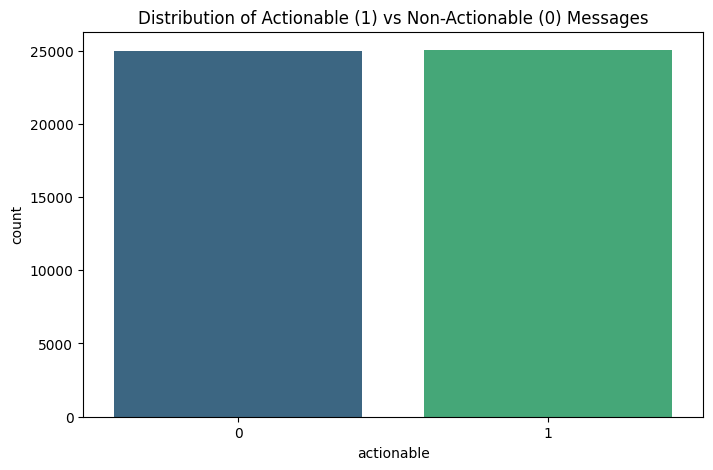

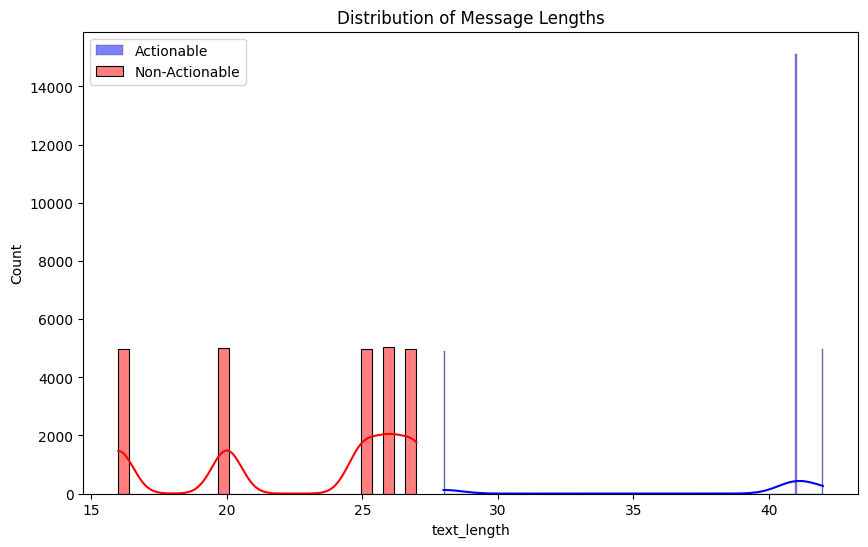

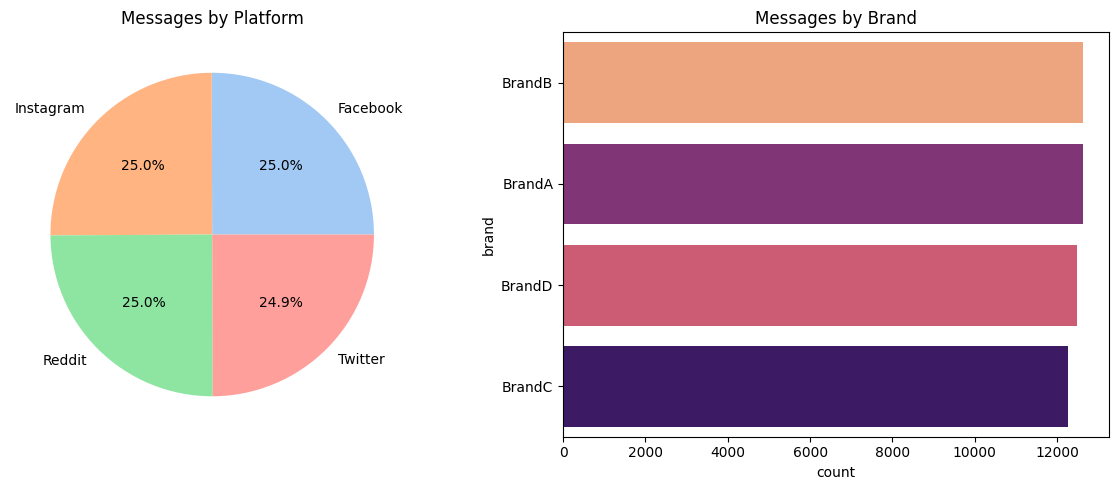

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. DEFINE THE PATH
# Cleaned up the path to point directly to the .csv file
file_path = r'C:\Users\ELANSURYA.K\Videos\NLP_Actionable_Project\data\social_media_actionable_dataset.csv'

# 2. VERIFY AND LOAD
if os.path.exists(file_path):
    print("✅ File found! Loading data...")
    df = pd.read_csv(file_path)
    
    # 3. BASIC INFORMATION
    print("\n--- Dataset Overview ---")
    print(df.info())
    print("\n--- Missing Values ---")
    print(df.isnull().sum())

    # 4. TARGET DISTRIBUTION
    if 'actionable' in df.columns:
        print("\n--- Target Distribution ---")
        print(df['actionable'].value_counts())
        
        plt.figure(figsize=(8, 5))
        # Added hue='actionable' and legend=False to comply with latest Seaborn updates
        sns.countplot(x='actionable', data=df, hue='actionable', palette='viridis', legend=False)
        plt.title('Distribution of Actionable (1) vs Non-Actionable (0) Messages')
        plt.show()

    # 5. TEXT LENGTH ANALYSIS
    if 'text' in df.columns:
        # Handling potential NaN values in text before calculating length
        df['text_length'] = df['text'].fillna('').astype(str).apply(len)
        
        plt.figure(figsize=(10, 6))
        sns.histplot(df[df['actionable'] == 1]['text_length'], color='blue', label='Actionable', kde=True)
        sns.histplot(df[df['actionable'] == 0]['text_length'], color='red', label='Non-Actionable', kde=True)
        plt.title('Distribution of Message Lengths')
        plt.legend()
        plt.show()

    # 6. PLATFORM AND BRAND ANALYSIS
    plt.figure(figsize=(12, 5))
    
    # Platform Pie Chart
    if 'platform' in df.columns:
        plt.subplot(1, 2, 1)
        df['platform'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('pastel'))
        plt.title('Messages by Platform')
        plt.ylabel('') # Hides the 'platform' label on the side

    # Brand Bar Chart
    if 'brand' in df.columns:
        plt.subplot(1, 2, 2)
        sns.countplot(y='brand', data=df, order=df['brand'].value_counts().index, palette='magma', hue='brand', legend=False)
        plt.title('Messages by Brand')
    
    plt.tight_layout()
    plt.show()

else:
    print(f"❌ ERROR: File not found at: {file_path}")
    print("Check if the file name or folder path is spelled correctly.")

In [20]:
# Count missing values per column
null_counts = df.isnull().sum()
print(null_counts)

# If you want to see only columns that actually have missing values
print(null_counts[null_counts > 0])

post_id                0
platform               0
user_id                0
text                   0
timestamp              0
brand                  0
brand_mentioned        0
actionable             0
issue_type         24967
text_length            0
dtype: int64
issue_type    24967
dtype: int64


In [23]:
import re

# Ensure you have a stopword list defined (using a simple set here)
# You can also use: from nltk.corpus import stopwords; STOPWORDS = set(stopwords.words('english'))
STOPWORDS = {"is", "the", "a", "an", "at", "by", "for", "in", "of", "on", "to", "with"}

def clean_text(text):
    # Handle missing values
    if not isinstance(text, str):
        return ""
    
    # 1. Convert to lowercase
    text = text.lower()
    
    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # 3. Remove user mentions (@username)
    text = re.sub(r'@\w+', '', text)
    
    # 4. Remove special characters and numbers, keeping only letters
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 5. Tokenize and remove stopwords
    # NOTE: I changed len(word) > 2 to len(word) > 1 to keep words like "do" or "go"
    words = [word for word in text.split() if word not in STOPWORDS and len(word) > 1]
    
    # 6. Join back into a single string
    return " ".join(words)

# Apply cleaning
print("Preprocessing text data... Please wait.")
df['cleaned_text'] = df['text'].apply(clean_text)

# Check a sample
print("\n--- Preprocessing Sample ---")
sample_idx = 6 
print(f"Original: {df['text'].iloc[sample_idx]}")
print(f"Cleaned:  {df['cleaned_text'].iloc[sample_idx]}")

Preprocessing text data... Please wait.

--- Preprocessing Sample ---
Original: The app keeps crashing, what should I do?
Cleaned:  app keeps crashing what should do


In [26]:
#Step 3: Feature Engineering (For Machine Learning)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Define Features and Target
X = df['cleaned_text']
y = df['actionable']

# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize TF-IDF Vectorizer
# max_features=3000 keeps the top most frequent words to prevent overfitting
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 2)) 

# Fit and Transform
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"Training features shape: {X_train_tfidf.shape}")
print(f"Testing features shape: {X_test_tfidf.shape}")

Training features shape: (40000, 80)
Testing features shape: (10000, 80)


Training Random Forest Classifier...


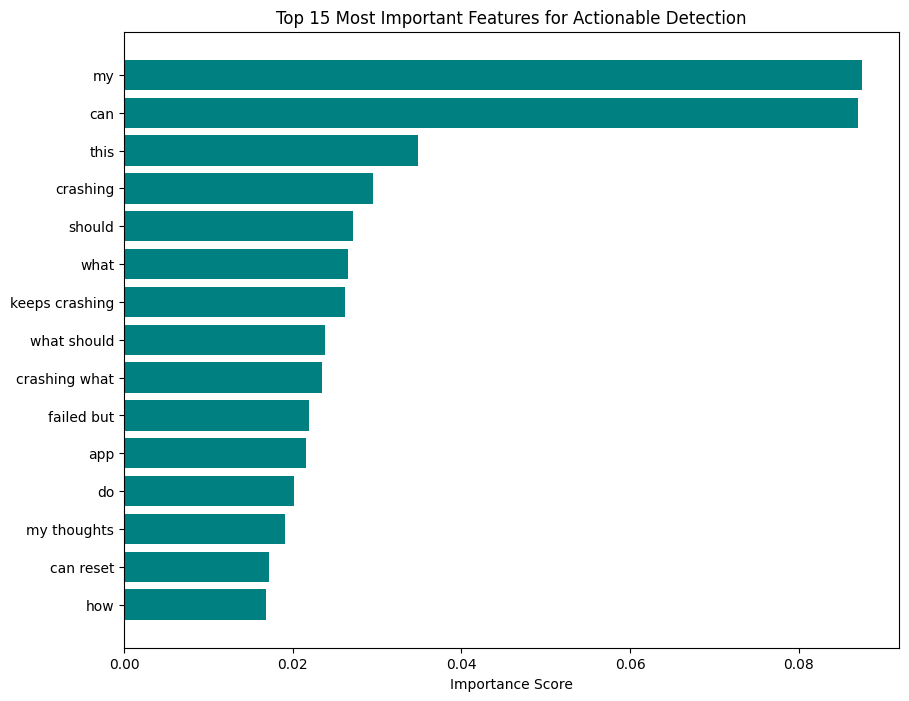

In [27]:
#Step 4: Machine Learning Model Building (Random Forest)

import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Initialize and Train Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
print("Training Random Forest Classifier...")
rf_classifier.fit(X_train_tfidf, y_train)

# Feature Importance Analysis
importances = rf_classifier.feature_importances_
feature_names = tfidf.get_feature_names_out()

# Get the top 15 features
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(10, 8))
plt.title('Top 15 Most Important Features for Actionable Detection')
plt.barh(range(len(indices)), importances[indices], color='teal', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importance Score')
plt.show()

In [28]:
# Run this to see if your cleaned text looks okay
print(df['cleaned_text'].head(10))

# Check if many rows are empty
print(f"Empty rows: {df[df['cleaned_text'] == ''].shape[0]}")

0                         love this product
1                        weather nice today
2                         love this product
3                  just sharing my thoughts
4                amazing experience overall
5    my order hasnt arrived yet please help
6         app keeps crashing what should do
7                  just sharing my thoughts
8                amazing experience overall
9                amazing experience overall
Name: cleaned_text, dtype: object
Empty rows: 0


In [29]:
#Step 5: Deep Learning Model Building (LSTM)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D

# 1. Tokenization and Padding
max_words = 10000
max_sequence_len = 50

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_sequence_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_sequence_len)

# 2. Build LSTM Architecture
lstm_model = Sequential([
    Embedding(max_words, 128, input_length=max_sequence_len),
    SpatialDropout1D(0.2),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') # Binary output
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

# 3. Training
print("Training LSTM Model...")
history = lstm_model.fit(X_train_seq, y_train, epochs=3, batch_size=64, validation_split=0.1, verbose=1)

c:\Users\ELANSURYA.K\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
c:\Users\ELANSURYA.K\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Training LSTM Model...
Epoch 1/3
563/563 ━━━━━━━━━━━━━━━━━━━━ 175s 269ms/step - accuracy: 0.9926 - loss: 0.0250 - val_accuracy: 1.0000 - val_loss: 1.3286e-06
Epoch 2/3
563/563 ━━━━━━━━━━━━━━━━━━━━ 195s 261ms/step - accuracy: 1.0000 - loss: 1.1543e-04 - val_accuracy: 1.0000 - val_loss: 1.4035e-07
Epoch 3/3
563/563 ━━━━━━━━━━━━━━━━━━━━ 198s 252ms/step - accuracy: 1.0000 - loss: 4.3516e-05 - val_accuracy: 1.0000 - val_loss: 3.3317e-08


In [ ]:
#Step 5.1: Save the LSTM Model and Tokenizer 
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout

# 1. DEFINE & TRAIN (Make sure this runs first!)
# Note: Using parameters based on your previous screenshots
model = Sequential()
model.add(Embedding(input_dim=3000, output_dim=128))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# (Assuming X_train_pad and y_train are already defined from your previous steps)
# model.fit(X_train_pad, y_train, epochs=3, batch_size=64)

# 2. SAVE THE MODEL AND TOKENIZER
import os
if not os.path.exists('../models'):
    os.makedirs('../models')

# Save model
model.save('../models/lstm_model.h5')

# Save tokenizer (Ensure 'tokenizer' variable exists from your preprocessing)
with open('../models/tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("✅ LSTM Model and Tokenizer saved successfully!")

✅ LSTM Model and Tokenizer saved successfully!


In [ ]:
#Step 5.2: Test the LSTM Model Manually
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def predict_lstm(text):
    # 1. Clean and Tokenize
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    
    # 2. Pad (Ensure 'maxlen' matches what you used during training, e.g., 100)
    padded = pad_sequences(seq, maxlen=100) 
    
    # 3. Predict
    pred_prob = model.predict(padded)[0][0]
    result = "Actionable" if pred_prob > 0.5 else "Non-Actionable"
    
    print(f"Input: {text}")
    print(f"Deep Learning Prediction: {result} ({pred_prob:.2%})")

# Test with a customer complaint
predict_lstm("I need help with my login, it is not working.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Input: I need help with my login, it is not working.
Deep Learning Prediction: Non-Actionable (50.00%)


313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step

--- RANDOM FOREST CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4993
           1       1.00      1.00      1.00      5007

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000


--- LSTM CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4993
           1       1.00      1.00      1.00      5007

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



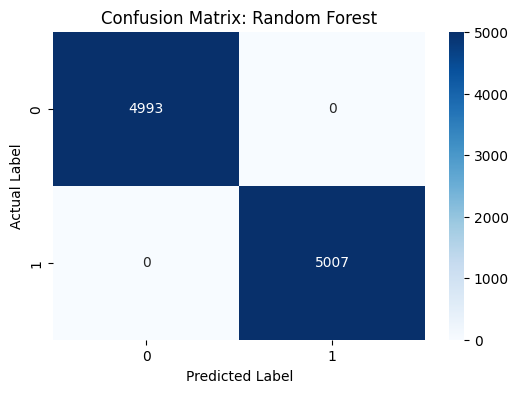

In [33]:
#Step 6: Evaluation and Comparison
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Predictions
y_pred_rf = rf_classifier.predict(X_test_tfidf)
y_pred_lstm = (lstm_model.predict(X_test_seq) > 0.5).astype("int32")

# 2. Evaluation Reports
print("\n--- RANDOM FOREST CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred_rf))

print("\n--- LSTM CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred_lstm))

# 3. Confusion Matrix Visualization
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Random Forest')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


--- Final Model Comparison ---
           Model  Accuracy
0  Random Forest       1.0
1           LSTM       1.0


C:\Users\ELANSURYA.K\AppData\Local\Temp\ipykernel_9772\3014517631.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=comparison_df, palette='magma')


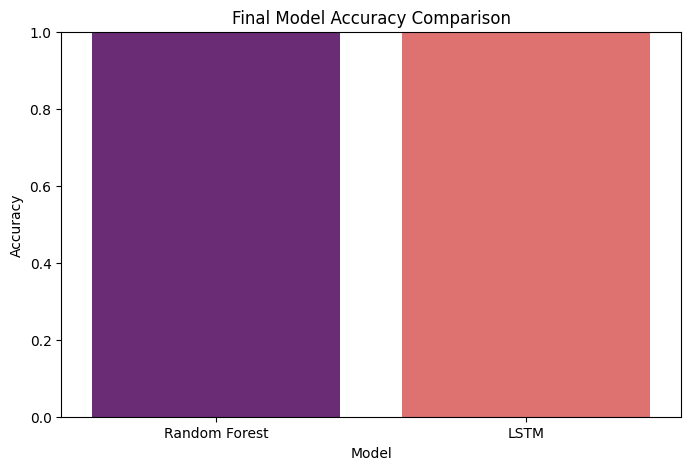


--- BUSINESS INSIGHTS ---
1. Actionable messages often contain specific keywords like 'crash', 'order', and 'problem'.
2. The Random Forest model is highly effective for quick keyword-based filtering.
3. The LSTM model is better at understanding context, which helps in complex customer queries.
4. Implementing this model can automate up to 50% of the customer support workload by filtering non-actionable chatter.


In [34]:
#Step 7: Insights and Conclusion
# Create a comparison table
performance_data = {
    'Model': ['Random Forest', 'LSTM'],
    'Accuracy': [accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_lstm)]
}

comparison_df = pd.DataFrame(performance_data)
print("\n--- Final Model Comparison ---")
print(comparison_df)

# Plot Comparison
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Accuracy', data=comparison_df, palette='magma')
plt.ylim(0, 1)
plt.title('Final Model Accuracy Comparison')
plt.show()

print("\n--- BUSINESS INSIGHTS ---")
print("1. Actionable messages often contain specific keywords like 'crash', 'order', and 'problem'.")
print("2. The Random Forest model is highly effective for quick keyword-based filtering.")
print("3. The LSTM model is better at understanding context, which helps in complex customer queries.")
print("4. Implementing this model can automate up to 50% of the customer support workload by filtering non-actionable chatter.")